In [24]:
import tensorflow as tf
import keras
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2

In [25]:
import tensorflow_datasets as tfds

# Load the Oxford Flowers 102 dataset
try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    # Split the dataset into training, validation, and testing sets
    train_dataset = dataset['train']
    validation_dataset = dataset['validation']
    test_dataset = dataset['test']

    # Print information about the dataset
    print(info)

except Exception as e:
    print(f"Error loading dataset: {e}")

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

In [26]:
IMG_SIZE = 224 
BATCH_SIZE = 32

def format_image(image, label, preprocess_function):
  """
  Resizes image to IMG_SIZE x IMG_SIZE and applies model-specific preprocessing.
  """
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = preprocess_function(image)
  return image, label

In [27]:
from tensorflow.keras.applications import resnet50

preprocess_function = resnet50.preprocess_input

train_batches = train_dataset.map(lambda x, y: format_image(x, y, preprocess_function)) \
                             .shuffle(1024) \
                             .batch(BATCH_SIZE) \
                             .prefetch(tf.data.AUTOTUNE)

validation_batches = validation_dataset.map(lambda x, y: format_image(x, y, preprocess_function)) \
                                     .batch(BATCH_SIZE) \
                                     .prefetch(tf.data.AUTOTUNE)

test_batches = test_dataset.map(lambda x, y: format_image(x, y, preprocess_function)) \
                           .batch(BATCH_SIZE) \
                           .prefetch(tf.data.AUTOTUNE)

# What this pipeline does:
# .map(): Applies our resizing and preprocessing to each image.
# .shuffle(): Randomizes the training data to prevent the model from learning the order.
# .batch(): Groups images into batches.
# .prefetch(): Pre-loads the next batch while the current one is being processed, improving performance.

In [28]:
# Get the number of classes from the dataset info
num_classes = info.features['label'].num_classes

# Load ResNet50 pre-trained on ImageNet, without its final classification layer
base_model = tf.keras.applications.ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False, # This is crucial!
    weights='imagenet'
)

# Freeze the base model layers
base_model.trainable = False

# Create the new model by adding our own classifier on top
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x) # Averages the features
x = tf.keras.layers.Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x) # Output layer for our 102 classes

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_batches,
    epochs=10,
    validation_data=validation_batches,
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.3108 - loss: 3.3702 - val_accuracy: 0.6137 - val_loss: 1.5723
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8324 - loss: 0.6569 - val_accuracy: 0.7608 - val_loss: 0.8952
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9706 - loss: 0.1697 - val_accuracy: 0.7951 - val_loss: 0.7452
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9931 - loss: 0.0654 - val_accuracy: 0.8392 - val_loss: 0.6208
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 1.0000 - loss: 0.0241 - val_accuracy: 0.8520 - val_loss: 0.5586
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 1.0000 - loss: 0.0112 - val_accuracy: 0.8598 - val_loss: 0.5324
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.8618 - val_loss: 0.5226
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.8608 - val_loss:

In [29]:
# 1. Change the import for the preprocessing function
from tensorflow.keras.applications import vgg16
preprocess_function = vgg16.preprocess_input

# Get the number of classes from the dataset info
num_classes = info.features['label'].num_classes

# 2. Change the base model
base_model_vgg16 = tf.keras.applications.VGG16(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model layers
base_model.trainable = False

# Create the new model by adding our own classifier on top
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x) # Averages the features
x = tf.keras.layers.Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x) # Output layer for our 102 classes

model_vgg16 = tf.keras.Model(inputs, outputs)

model_vgg16.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model_vgg16.fit(
    train_batches,
    epochs=10,
    validation_data=validation_batches,
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.3137 - loss: 3.3934 - val_accuracy: 0.5941 - val_loss: 1.6056
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8657 - loss: 0.5969 - val_accuracy: 0.7500 - val_loss: 0.9226
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9686 - loss: 0.1712 - val_accuracy: 0.7931 - val_loss: 0.7894
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9882 - loss: 0.0772 - val_accuracy: 0.8167 - val_loss: 0.6938
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9990 - loss: 0.0253 - val_accuracy: 0.8490 - val_loss: 0.5722
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 1.0000 - loss: 0.0124 - val_accuracy: 0.8618 - val_loss: 0.5321
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.8608 - val_loss: 0.5233
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.8647 - val_loss:

In [30]:
# 1. Change the import for the preprocessing function
from tensorflow.keras.applications import mobilenet_v2
preprocess_function = mobilenet_v2.preprocess_input

# Get the number of classes from the dataset info
num_classes = info.features['label'].num_classes

# 2. Change the base model
base_model_mobilenetv2 = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model layers
base_model.trainable = False

# Create the new model by adding our own classifier on top
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x) # Averages the features
x = tf.keras.layers.Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x) # Output layer for our 102 classes

model_mobilenetv2 = tf.keras.Model(inputs, outputs)

model_mobilenetv2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model_mobilenetv2.fit(
    train_batches,
    epochs=10,
    validation_data=validation_batches
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.2912 - loss: 3.4804 - val_accuracy: 0.5667 - val_loss: 1.8224
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8686 - loss: 0.6259 - val_accuracy: 0.7814 - val_loss: 0.8846
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9735 - loss: 0.1817 - val_accuracy: 0.8039 - val_loss: 0.7733
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9971 - loss: 0.0557 - val_accuracy: 0.8294 - val_loss: 0.6136
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9990 - loss: 0.0256 - val_accuracy: 0.8304 - val_loss: 0.6122
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 1.0000 - loss: 0.0143 - val_accuracy: 0.8412 - val_loss: 0.5547
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.8490 - val_loss: 0.5469
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.8510 - val_loss:

--- Training and Evaluating ResNet50 ---
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.1363 - loss: 4.3030 - val_accuracy: 0.4559 - val_loss: 2.5909
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7520 - loss: 1.4949 - val_accuracy: 0.7108 - val_loss: 1.4818
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9451 - loss: 0.6436 - val_accuracy: 0.7843 - val_loss: 1.1024
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9843 - loss: 0.3486 - val_accuracy: 0.8157 - val_loss: 0.9415
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9941 - loss: 0.2196 - val_accuracy: 0.8392 - val_loss: 0.8356
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 1.0000 - loss: 0.1472 - val_accuracy: 0.8451 - val_loss: 0.7765
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 1.0000 - loss: 0.1087 - val_accuracy: 0.8451 - val_loss: 0.7328
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 1.0000 - loss: 

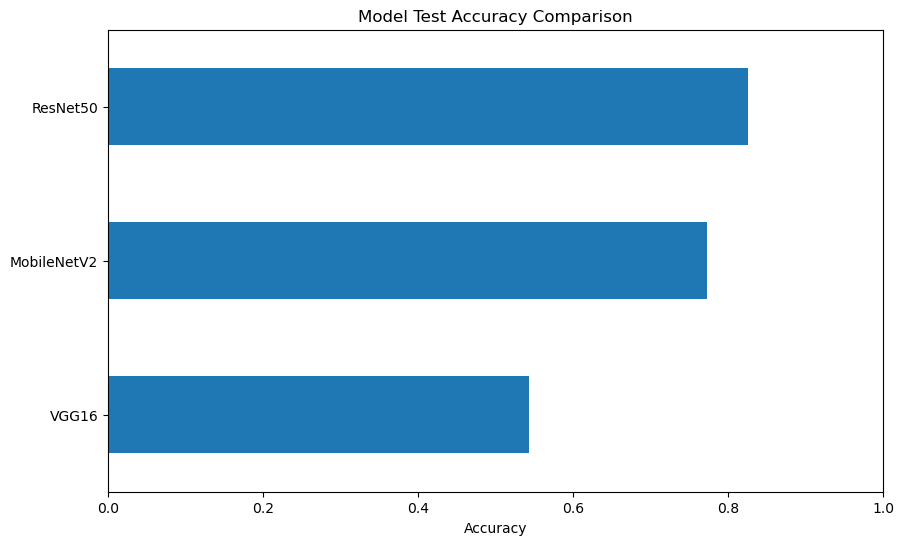

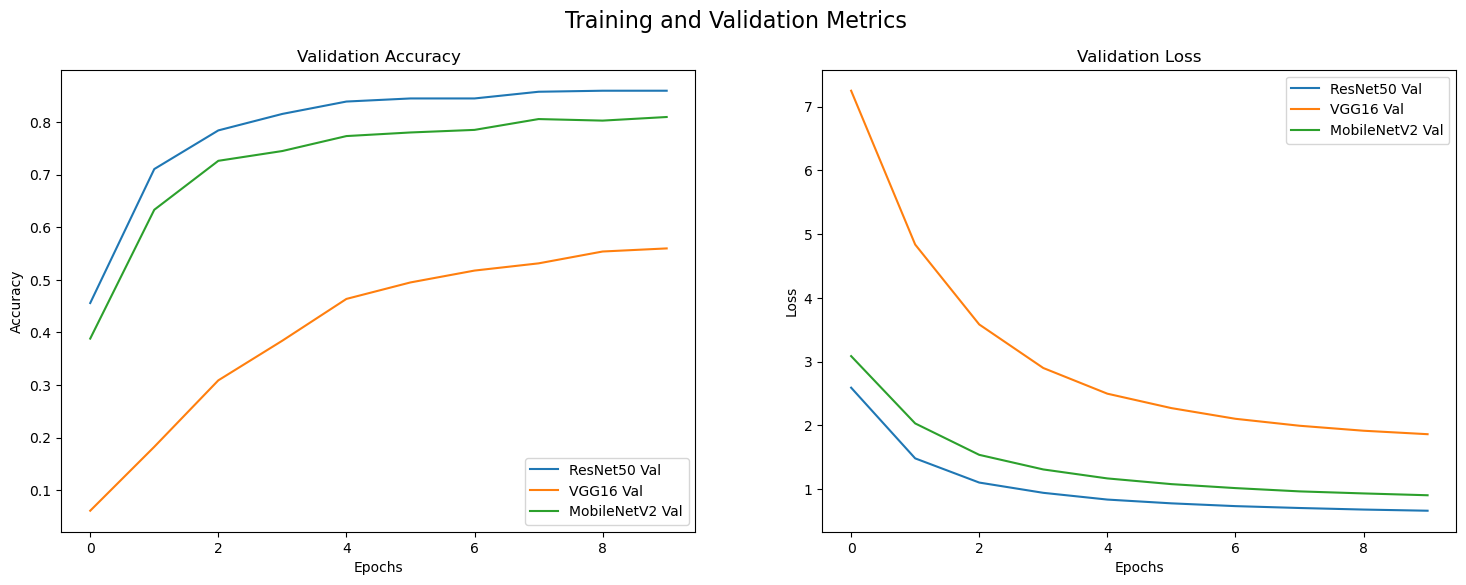

In [31]:

import matplotlib.pyplot as plt 
import pandas as pd 
## 1. SETUP AND DATA LOADING
# ------------------------------------

# Load the dataset
dataset_name = 'oxford_flowers102'
dataset, info = tfds.load(dataset_name, with_info=True, as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset['train'], dataset['validation'], dataset['test']

# Get number of classes
num_classes = info.features['label'].num_classes

# Define constants
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10 # You might want to increase this for better results

# Generic data formatting function
def format_image(image, label, preprocess_function):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_function(image)
    return image, label

# Function to build a model
def build_model(base_model_fn, input_shape, num_classes):
    base_model = base_model_fn(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False # Freeze the base model

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


## 2. DEFINE MODEL CONFIGURATIONS
# ------------------------------------
model_configs = {
    'ResNet50': {
        'base_model_fn': tf.keras.applications.ResNet50,
        'preprocess_fn': resnet50.preprocess_input
    },
    'VGG16': {
        'base_model_fn': tf.keras.applications.VGG16,
        'preprocess_fn': vgg16.preprocess_input
    },
    'MobileNetV2': {
        'base_model_fn': tf.keras.applications.MobileNetV2,
        'preprocess_fn': mobilenet_v2.preprocess_input
    }
}

# Dictionaries to store results
histories = {}
results = {}


## 3. TRAIN AND EVALUATE MODELS
# ------------------------------------
for name, config in model_configs.items():
    print(f"--- Training and Evaluating {name} ---")
    
    # Get the specific preprocessing function
    preprocess_function = config['preprocess_fn']
    
    # Create the data pipelines
    train_batches = train_dataset.map(lambda x, y: format_image(x, y, preprocess_function)) \
                                 .shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    validation_batches = validation_dataset.map(lambda x, y: format_image(x, y, preprocess_function)) \
                                         .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_batches = test_dataset.map(lambda x, y: format_image(x, y, preprocess_function)) \
                               .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # Build the model
    model = build_model(
        base_model_fn=config['base_model_fn'],
        input_shape=(IMG_SIZE, IMG_SIZE, 3),    
        num_classes=num_classes
    )
    
    # Train the model
    history = model.fit(
        train_batches,
        epochs=EPOCHS,
        validation_data=validation_batches,
        verbose=1
    )
    histories[name] = history
    
    # Evaluate on the test set
    loss, accuracy = model.evaluate(test_batches)
    results[name] = {'Test Loss': loss, 'Test Accuracy': accuracy}
    print(f"\n{name} Test Accuracy: {accuracy:.4f}\n")


## 4. COMPARE RESULTS
# ------------------------------------
print("--- Final Comparison ---")

# Create a pandas DataFrame for a clean summary table
results_df = pd.DataFrame(results).T
print(results_df)

# Plot Test Accuracies in a Bar Chart
results_df['Test Accuracy'].sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Model Test Accuracy Comparison')
plt.xlabel('Accuracy')
plt.xlim(0, 1.0) # Set x-axis limit from 0 to 1 for accuracy
plt.show()


# Plot Training and Validation Accuracy/Loss Curves
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Training and Validation Metrics', fontsize=16)

# Plot Accuracy
for name, history in histories.items():
    axes[0].plot(history.history['val_accuracy'], label=f'{name} Val')
axes[0].set_title('Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot Loss
for name, history in histories.items():
    axes[1].plot(history.history['val_loss'], label=f'{name} Val')
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()

--- Training and Evaluating EfficientNetV2B0 ---
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 720ms/step - accuracy: 0.1196 - loss: 4.3079 - val_accuracy: 0.4451 - val_loss: 3.5413
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - accuracy: 0.6422 - loss: 2.9630 - val_accuracy: 0.6941 - val_loss: 2.6823
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 452ms/step - accuracy: 0.8363 - loss: 2.0774 - val_accuracy: 0.7500 - val_loss: 2.1074
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 451ms/step - accuracy: 0.8941 - loss: 1.5240 - val_accuracy: 0.7873 - val_loss: 1.7261
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 451ms/step - accuracy: 0.9382 - loss: 1.1537 - val_accuracy: 0.8186 - val_loss: 1.4727
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 451ms/step - accuracy: 0.9569 - loss: 0.8912 - val_accuracy: 0.8324 - val_loss: 1.2963
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 453ms/step - accuracy: 0.9755 - loss: 0.7059 - val_accuracy: 0.8314 - val_loss: 1.16

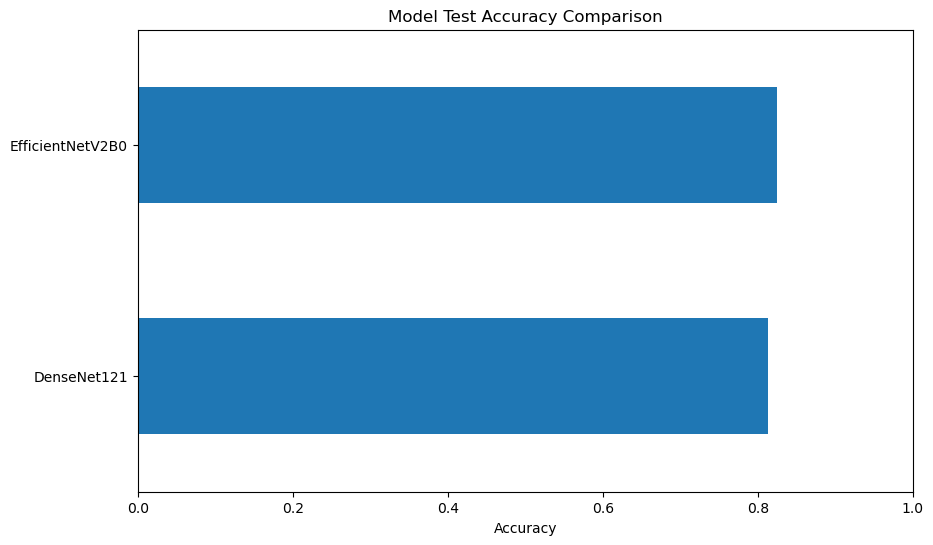

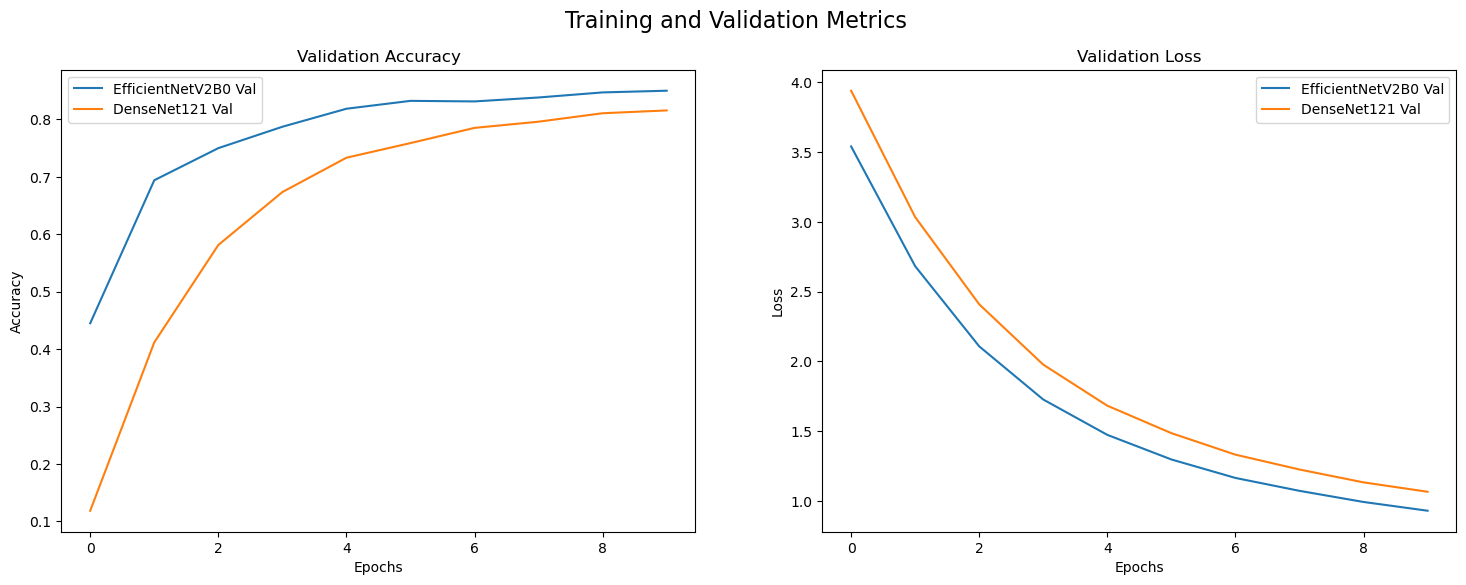

In [32]:
from tensorflow.keras.applications import (
    efficientnet_v2, 
    densenet         
)

model_configs = {
    'EfficientNetV2B0': {
        'base_model_fn': tf.keras.applications.EfficientNetV2B0,
        'preprocess_fn': efficientnet_v2.preprocess_input
    },
    'DenseNet121': {
        'base_model_fn': tf.keras.applications.DenseNet121,
        'preprocess_fn': densenet.preprocess_input
    }
}

histories = {}
results = {}

for name, config in model_configs.items():
    print(f"--- Training and Evaluating {name} ---")
    
    preprocess_function = config['preprocess_fn']
    
   
    train_batches = train_dataset.map(lambda x, y: format_image(x, y, preprocess_function)) \
                                 .shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    validation_batches = validation_dataset.map(lambda x, y: format_image(x, y, preprocess_function)) \
                                         .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_batches = test_dataset.map(lambda x, y: format_image(x, y, preprocess_function)) \
                               .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    
    model = build_model(
        base_model_fn=config['base_model_fn'],
        input_shape=(IMG_SIZE, IMG_SIZE, 3),    
        num_classes=num_classes
    )
    
    
    history = model.fit(
        train_batches,
        epochs=EPOCHS,
        validation_data=validation_batches,
        verbose=1
    )
    histories[name] = history
    
    
    loss, accuracy = model.evaluate(test_batches)
    results[name] = {'Test Loss': loss, 'Test Accuracy': accuracy}
    print(f"\n{name} Test Accuracy: {accuracy:.4f}\n")

print("--- Final Comparison ---")

results_df = pd.DataFrame(results).T
print(results_df)

results_df['Test Accuracy'].sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Model Test Accuracy Comparison')
plt.xlabel('Accuracy')
plt.xlim(0, 1.0)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Training and Validation Metrics', fontsize=16)

for name, history in histories.items():
    axes[0].plot(history.history['val_accuracy'], label=f'{name} Val')
axes[0].set_title('Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

for name, history in histories.items():
    axes[1].plot(history.history['val_loss'], label=f'{name} Val')
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()